In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
SEED = 0

In [3]:
df_2019 = pd.read_csv('../data/image_embeddings/jpeg-isic2019-1024x1024_train.csv').set_index('image_name')

In [4]:
app_data = pd.read_csv('../data/APP_DATA.csv')
unique_app_data = app_data.drop_duplicates('origin').copy()
unique_app_data['origin_trunc'] = unique_app_data.origin.str[:-4]
app_data_merged = df_2019.merge(unique_app_data[['origin_trunc']], left_index=True, right_on='origin_trunc')
app_data_merged = app_data_merged.rename(columns={'origin_trunc': 'image_name'})\
                                    .reset_index(drop=True).sort_values('image_name')

In [5]:
app_data_merged.head(3)

,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,image_name
0,-1,male,45.0,NaN,NV,benign,0,2,600,450,ISIC_0024306
1,-1,male,50.0,lower extremity,NV,benign,0,26,600,450,ISIC_0024307
2,-1,female,55.0,NaN,NV,benign,0,16,600,450,ISIC_0024308


In [6]:
#app_data_merged.to_csv('app_metadata.csv', index=False)

# Embeddings

In [7]:
#model = 'sub_9c_b5ns_1.5e_640_ext_15ep_best.csv'
#model = 'sub_9c_b4ns_768_768_ext_15ep_best.csv'
model = 'sub_9c_b5ns_448_ext_15ep-newfold_best.csv'
raw_embeddings = pd.read_csv(f'../data/image_embeddings/embeddings/{model}').sort_values('image_name')\
                        .drop('image_name', axis=1).values

In [8]:
raw_embeddings.shape

(7818, 2048)

In [9]:
embeddings = pd.DataFrame(TSNE(random_state=SEED).fit_transform(raw_embeddings))
embeddings.columns = ['x', 'y']

In [10]:
embeddings_metadata = pd.concat((embeddings, app_data_merged.sort_values('image_name')), axis=1)

In [11]:
embeddings_metadata

,x,y,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,image_name
0,-24.995012,28.072512,-1,male,45.0,NaN,NV,benign,0,2,600,450,ISIC_0024306
1,-17.822762,-36.965939,-1,male,50.0,lower extremity,NV,benign,0,26,600,450,ISIC_0024307
2,-20.128687,-14.933958,-1,female,55.0,NaN,NV,benign,0,16,600,450,ISIC_0024308
3,-41.579044,33.419640,-1,male,40.0,NaN,NV,benign,0,10,600,450,ISIC_0024309
4,71.191612,-4.708953,-1,male,60.0,anterior torso,MEL,malignant,1,0,600,450,ISIC_0024310
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7813,27.277769,31.760544,-1,male,50.0,anterior torso,NV,benign,0,14,600,450,ISIC_0034314
7814,82.946732,19.735231,-1,male,85.0,upper extremity,MEL,malignant,1,4,600,450,ISIC_0034316
7815,57.939789,3.109331,-1,female,70.0,lower extremity,MEL,malignant,1,12,600,450,ISIC_0034317
7816,44.904594,2.378647,-1,male,30.0,NaN,NV,benign,0,2,600,450,ISIC_0034319


In [22]:
from plotly.express import scatter

In [ ]:
ISIC_0032984
ISIC_0032096
ISIC_0028598
ISIC_0033006
ISIC_0029148
ISIC_0029094
ISIC_0032037
ISIC_0024568
ISIC_0029299

In [25]:
scatter(embeddings_metadata,  x='x', y='y', color='benign_malignant', hover_data='image_name')

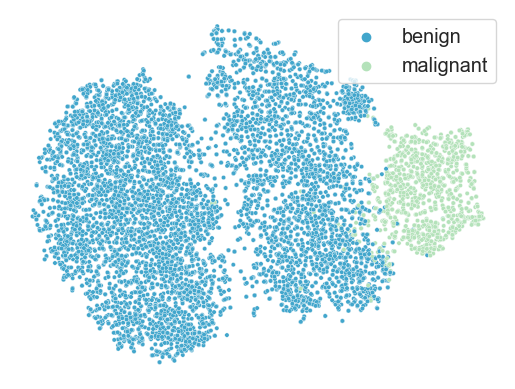

In [32]:
sns.set(font_scale=1.3)
samples = embeddings_metadata
with sns.axes_style("white"):
    sns.scatterplot(samples, x='x', y='y', hue='benign_malignant', 
                    alpha=1, palette='GnBu_r', s=10)
    plt.legend(title='')
    plt.axis('off')
    plt.savefig("image_embeddings.svg", bbox_inches='tight', dpi=300)
    plt.show()

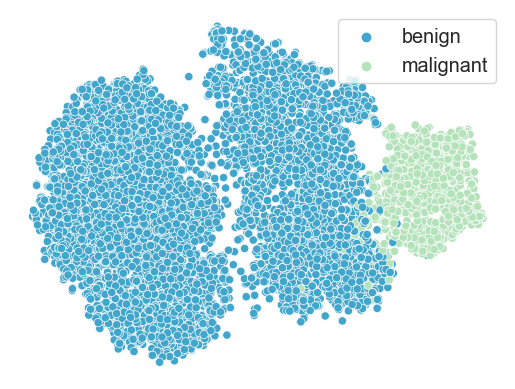

In [33]:
sns.set(font_scale=1.3)
samples = embeddings_metadata
with sns.axes_style("white"):
    sns.scatterplot(samples, x='x', y='y', hue='benign_malignant', 
                    alpha=1, palette='GnBu_r')
    plt.legend(title='')
    plt.axis('off')
    #plt.savefig("image_embeddings.svg", bbox_inches='tight', dpi=300)
    plt.show()

# Creating image clusters

In [12]:
X = embeddings_metadata[['x', 'y']].values

In [13]:
n_clusters = 100
km = KMeans(n_clusters=n_clusters, init='random', n_init=10, max_iter=300, 
    tol=1e-04, random_state=SEED)
#, init='random', n_init=10, max_iter=300, tol=1e-04, 
clusters = km.fit_predict(X)

In [14]:
embeddings_metadata['cluster'] = clusters

In [15]:
import matplotlib.lines as mlines

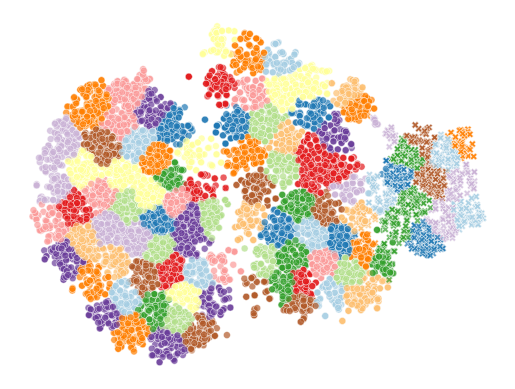

In [16]:
sns.scatterplot(embeddings_metadata, x='x', y='y', hue='cluster', style='benign_malignant', alpha=0.7, s=25,
               palette='Paired_r')
#Dark2
                #sns.color_palette("husl", n_clusters))
plt.legend([],[], frameon=False)
#plt.legend()
#handles, labels = plt.gca().get_legend_handles_labels()
#handles[0] = mlines.Line2D([], [], color='darkgray', marker='o', linestyle='None', markersize=6)
#handles[1] = mlines.Line2D([], [], color='darkgray', marker='x', linestyle='None', markersize=6)
#new_labels = ['benign', 'malignant']
#by_label = dict(zip(new_labels, handles[:2]))
#plt.legend(by_label.values(), by_label.keys(), title='Malignancy')
plt.axis('off')
#plt.savefig("image_clusters.svg", bbox_inches='tight', dpi=300)
plt.show()

In [17]:
embeddings_metadata.groupby('cluster').count().describe()

,x,y,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,image_name
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,78.180000,78.180000,78.180000,78.180000,77.750000,62.790000,78.180000,78.180000,78.180000,78.180000,78.180000,78.180000,78.180000
std,18.315076,18.315076,18.315076,18.315076,18.241575,15.820518,18.315076,18.315076,18.315076,18.315076,18.315076,18.315076,18.315076
min,31.000000,31.000000,31.000000,31.000000,30.000000,25.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
25%,67.500000,67.500000,67.500000,67.500000,67.500000,52.000000,67.500000,67.500000,67.500000,67.500000,67.500000,67.500000,67.500000
50%,78.000000,78.000000,78.000000,78.000000,78.000000,63.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
75%,89.000000,89.000000,89.000000,89.000000,87.250000,74.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
max,148.000000,148.000000,148.000000,148.000000,148.000000,112.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000


In [73]:
#embeddings_metadata.to_csv(f'data/image_clusters_{n_clusters}.csv', index=False)